In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller
from pylab import rcParams
from scipy.stats import f


/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
## load dataset
df = pd.read_csv("data1.csv",low_memory=False)
df1 = df.drop('Unnamed: 0', axis=1)


In [3]:
# resample the dataset to contain daily measurements
energy_consumption_cols = ['gen..kW.', 'House.overall..kW.', 'Dishwasher..kW.','Home.office..kW.','Fridge..kW.', 'Wine.cellar..kW.', 'Garage.door..kW.', 'Barn..kW.', 'Well..kW.', 'Microwave..kW.','Living.room..kW.', 'Furnace..kW.', 'Kitchen..kW.']
df_dias = df1[energy_consumption_cols].resample('1d', closed='left', label='left').sum()

In [4]:
PRED_WINDOW = 15
# Split data into training and testing sets
train_set, test_set = train_test_split(df_dias, train_size=len(df_dias) - PRED_WINDOW, shuffle=False)
# Get time indexes
time_index_train = train_set.index.to_numpy()
time_index_test = test_set.index.to_numpy()

<Figure size 1080x720 with 0 Axes>

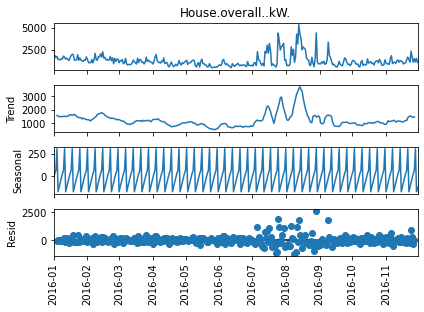

In [5]:
# Let's see if the daily consumed energy of the home follows any specific patterns
decomposition = seasonal_decompose(train_set["House.overall..kW."], model="additive")
plt.figure(figsize=(15, 10))
fig = decomposition.plot()
plt.xticks(rotation=90)
plt.show()

# we see weekly seasonality

In [6]:
from pmdarima import auto_arima
model_name = 'SARIMA'

# Ajuste del modelo SARIMA
sarima_model = auto_arima(train_set["House.overall..kW."], 
                          start_p=1, start_q=1,
                          max_p=10, max_q=10, 
                          m=7,  # Frecuencia estacional semanal
                          start_P=0, start_Q=0,
                          max_P=10, max_Q=10,
                          seasonal=True, 
                          d=None, D=None, 
                          trace=True, 
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True, 
                          test="adf")

display(sarima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=5148.069, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5331.222, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5144.458, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5208.231, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=5811.685, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=5151.936, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=5143.881, Time=0.34 sec
 ARIMA(1,0,0)(3,0,0)[7] intercept   : AIC=5144.453, Time=1.02 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=5144.296, Time=0.81 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=5147.679, Time=0.20 sec
 ARIMA(1,0,0)(3,0,1)[7] intercept   : AIC=5141.794, Time=1.46 sec
 ARIMA(1,0,0)(4,0,1)[7] intercept   : AIC=5143.961, Time=1.68 sec
 ARIMA(1,0,0)(3,0,2)[7] intercept   : AIC=5143.753, Time=1.86 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,0,0)(4,0,0)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  335
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 7)   Log Likelihood               -2563.897
Date:                             Tue, 21 May 2024   AIC                           5141.794
Time:                                     19:42:27   BIC                           5168.493
Sample:                                 01-01-2016   HQIC                          5152.438
                                      - 11-30-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    432.2173    213.226      2.027      0.043      14.302     850.132
ar.L1          0.6170      0.035     17.431      0.000       0.548       0.686
ar.S.L7       -0.1838      0.485     -0.379      0.705      -1.134       0.766
ar.S.L14       0.1582      0.084      1.877      0.060      -0.007       0.323
ar.S.L21       0.1259      0.054      2.319      0.020       0.019       0.232
ma.S.L7        0.3148      0.485      0.649      0.516      -0.636       1.265
sigma2      2.592e+05   1.04e+04     24.906      0.000    2.39e+05     2.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):              2986.44
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               5.19   Skew:                             2.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
def plot_predicted_values2(col,pred_col):
    plt.figure(figsize=(15, 10))
    plt.plot(time_index_train, train_set[col].to_numpy(), label='train set - observed')
    plt.plot(time_index_test, test_set[col].to_numpy(), label='test set - observed')
    plt.plot(time_index_train, train_set[pred_col].to_numpy(), label='train set - predicted')
    plt.plot(time_index_test, test_set[pred_col].to_numpy(), label='test set - predicted')
    plt.ylabel(col)
    plt.title(f'15-day energy consumption prediction using {pred_col} model')
    plt.legend()
    plt.show()

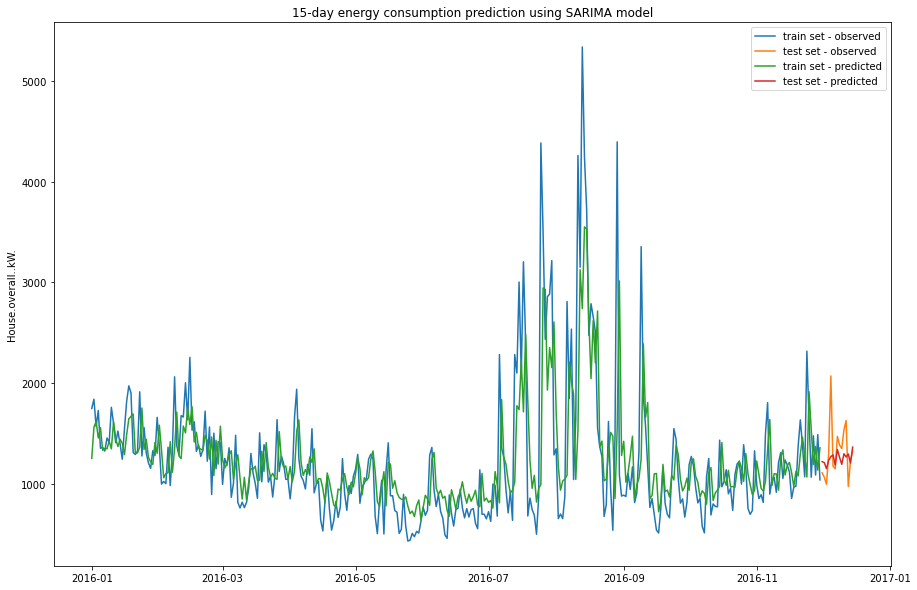

The RMSE of SARIMA on the test set is 266.56 kW


In [8]:
sarima_model.fit(train_set["House.overall..kW."])
sarima_preds = sarima_model.predict(n_periods=PRED_WINDOW, return_conf_int=False, params = sarima_model.params)
train_set["House.overall..kW."] = train_set["House.overall..kW."]
train_set[model_name] = sarima_model.predict_in_sample()
test_set[model_name] = sarima_preds
plot_predicted_values2("House.overall..kW.",'SARIMA')

# Calculate RMSE
error = round(np.sqrt(mean_squared_error(test_set["House.overall..kW."], test_set[model_name])),2)
print(f'The RMSE of {model_name} on the test set is {error} kW')

In [9]:
# Calculate MAE for test set
mae_test = round(mean_absolute_error(test_set["House.overall..kW."], test_set[model_name]), 2)
print(f'The MAE of {model_name} on the test set is {mae_test} kW')

# Calculate MAE for training set
mae_train = round(mean_absolute_error(train_set["House.overall..kW."], train_set[model_name]), 2)
print(f'The MAE of {model_name} on the training set is {mae_train} kW')
ov = f.cdf(mae_train/mae_test, 334, 14)

print(f'The F-distribution CDF value is {ov}')

# CDF interpretation
if ov > 0.5:
    print(f"A high CDF value of {ov} suggests that the model's performance is consistent between the training and test sets, indicating good generalization.")
else:
    print(f"A low CDF value of {ov} suggests that there may be a significant difference in performance between the training and test sets, indicating potential overfitting or underfitting.")


The MAE of SARIMA on the test set is 187.98 kW
The MAE of SARIMA on the training set is 307.39 kW
The F-distribution CDF value is 0.8555184069359777
A high CDF value of 0.8555184069359777 suggests that the model's performance is consistent between the training and test sets, indicating good generalization.
